In [7]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0
torch:  1.10 ; cuda:  cu113
detectron2: 0.6


In [8]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from pathlib import Path

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# coco dataset
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


In [9]:
# Download COCO val
if not Path("./data/coco").exists():
    torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')
    !unzip -q tmp.zip -d data && rm tmp.zip

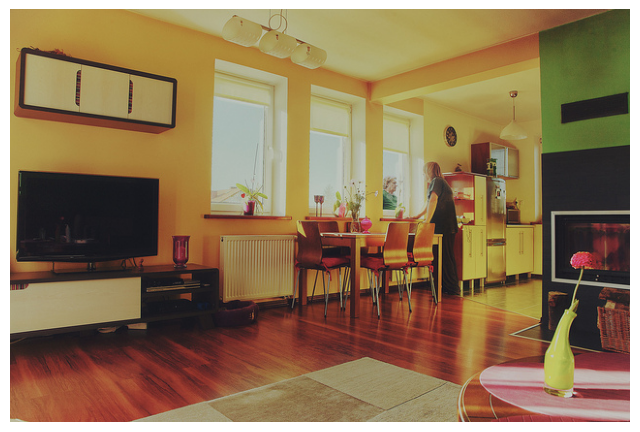

In [10]:
im = cv2.imread("./data/coco/images/val2017/000000000139.jpg")

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/kyungpyo/git/Ensemble-Object-Detection-using-Detectron2/env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/kyungpyo/git/Ensemble-Object-Detection-using-Detectron2/env/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs["instances"].scores)

for data in outputs["instances"].pred_classes:
    num = data.item()
    print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[num])

tensor([ 0, 56, 62, 56, 75, 72, 62, 72, 58,  0, 60, 56, 75, 74, 75, 75, 56, 39,
        72, 60, 75], device='cuda:0')
Boxes(tensor([[417.3340, 159.2698, 464.9932, 302.2742],
        [294.7582, 220.0869, 350.0292, 316.5282],
        [ 11.6043, 167.7195, 155.3132, 264.1222],
        [359.8039, 215.1343, 436.3195, 319.8536],
        [240.7737, 198.4749, 253.5157, 212.7433],
        [492.7741, 171.5544, 512.9581, 282.2671],
        [555.2312, 208.8119, 639.8697, 292.7118],
        [447.0272, 168.0226, 512.8493, 294.3363],
        [230.3627, 175.2072, 266.8033, 213.6973],
        [384.3799, 174.0284, 400.7446, 207.9433],
        [472.7986, 353.6075, 636.8516, 424.6628],
        [414.8886, 218.7234, 440.8944, 305.4774],
        [352.1933, 208.2724, 360.2508, 220.6084],
        [449.2539, 121.4658, 461.4014, 142.1424],
        [352.4831, 207.7334, 361.3527, 229.8627],
        [166.6290, 233.8118, 186.4724, 268.5610],
        [304.9307, 216.5564, 347.2542, 231.9534],
        [549.5787, 302.514

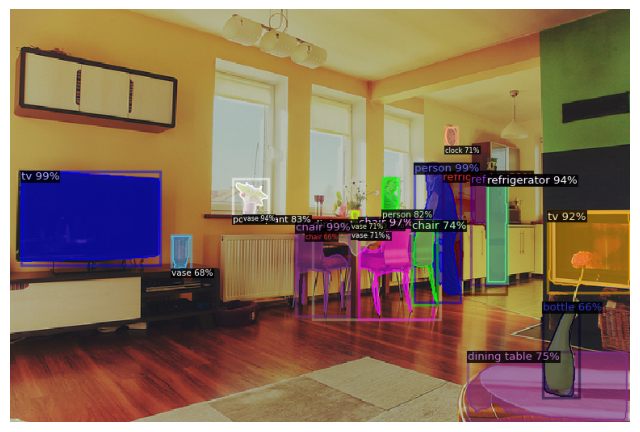

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(8,8))
plt.imshow(out.get_image())
plt.axis('off')
plt.show()

## COCO Object Detection Results Format
```
[
    {
        "image_id": int, 
        "category_id": int, 
        "bbox": [x,y,width,height], 
        "score": float,
    }
]
```

In [9]:
data_path = Path("./data/coco")
data_path_gt = data_path / "annotations/instances_val2017.json"
data_path_img = data_path / "images"

coco_gt = COCO(data_path_gt)
# coco_dt = coco_gt.loadRes(coco_results)

print("anns:", len(coco_gt.anns))
print("imgToAnns:", len(coco_gt.imgToAnns))
print("catToImgs:", len(coco_gt.catToImgs))
print("imgs:", len(coco_gt.imgs))
print("cats:", len(coco_gt.cats))

# print("anns:", coco_gt.anns[0])
# print("imgToAnns:", coco_gt.imgToAnns[0])
# print("catToImgs:", coco_gt.catToImgs[0])
# print("imgs:", coco_gt.imgs[0])
# print("cats:", coco_gt.cats[0])

# print(coco_dt)

# coco_eval = COCOeval(coco_gt, coco_dt, iou_type)
# # Use the COCO default keypoint OKS sigmas unless overrides are specified
# if kpt_oks_sigmas:
#     coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()



# cocoGt = COCO(glob.glob('../coco/annotations/instances_val*.json')[0])  # initialize COCO ground truth api
# cocoDt = cocoGt.loadRes(f)  # initialize COCO pred api

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
anns: 36781
imgToAnns: 4952
catToImgs: 80
imgs: 5000
cats: 80


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision.datasets import CocoDetection
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from detectron2.modeling import build_model
from detectron2.evaluation.coco_evaluation import instances_to_coco_json
from detectron2.evaluation.coco_evaluation import COCOEvaluator
import itertools

In [5]:
data_path = Path("./data/coco")
data_path_img = data_path / "images/val2017"
data_path_gt = data_path / "annotations/instances_val2017.json"

coco_dataset = CocoDetection(root=data_path_img, annFile=data_path_gt)
print(len(coco_dataset))

for image, target in coco_dataset:
    for elem in target:
        # print(elem["image_id"])
        break


loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
5000


In [16]:
def evaluate(model, data_loader, device, data_path_gt):
    model.eval()
    tk0 = tqdm(data_loader, total=len(data_loader))
    pil_to_tensor = transforms.ToTensor()
    count = 0
    results = []
    image_ids = []
    predictions = []
    for step, (images, targets) in enumerate(tk0):
        images = [dict(image=pil_to_tensor(image)) for image in images]
        outputs = model(images)

        for idx, target in enumerate(targets):
            image_id = None
            for elem in target:
                image_id = elem["image_id"]

                if image_id is None:
                    break

                image_ids.append(dict(id=image_id))
                break
            if image_id is None:
                continue

            prediction = dict(image_id=image_id)
            instances = outputs[idx]["instances"].to("cpu")
            prediction["instances"] = instances_to_coco_json(instances, image_id)
            # break
            predictions.append(prediction)

            # for _, value in outputs[idx].items():
            #     assert len(value.pred_boxes) == len(value.scores) == len(value.pred_classes)
            #     value_len = len(value.pred_boxes)
            #     for idx_value in range(value_len):
            #         cat_id = int(value.pred_classes[idx_value])
            #         bbox = value.pred_boxes[idx_value].tensor.cpu().detach().numpy().squeeze()
            #         area = float(value.pred_boxes[idx_value].area().cpu().detach())
            #         score = float(value.scores[idx_value].cpu().detach())
            #         results.append({
            #             "id": count,
            #             "image_id": image_id,
            #             "category_id": cat_id,
            #             "bbox": bbox,
            #             "segmentation": [],
            #             "ignore": 0,
            #             "area": area,
            #             "iscrowd": 0,
            #             "score": score,
            #         })
            #         count += 1
        # break
    # print(len(results))
    # predictions = dict(images=image_ids, annotations=results)
    MetadataCatalog.get("coco_2017_val")
    reverse_id_mapping = {
                    v: k for k, v in MetadataCatalog.get("coco_2017_val").thing_dataset_id_to_contiguous_id.items()
                }
    coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
    for result in coco_results:
        result["category_id"] = reverse_id_mapping[result["category_id"]]
        
    coco_gt = COCO(data_path_gt)
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

def collate_fn(batch):
    return tuple(zip(*batch))


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():

    BATCH_SIZE = 16

    coco_dataloader = DataLoader(
        coco_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )
    model = build_model(cfg)

    coco_eval = evaluate(model, coco_dataloader, device, data_path_gt)

  0%|          | 0/313 [00:00<?, ?it/s]/home/kyungpyo/git/Ensemble-Object-Detection-using-Detectron2/env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
100%|██████████| 313/313 [02:10<00:00,  2.39it/s]


loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.92s).
Accumulating evaluation results...
DONE (t=2.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets